In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('HI')

HI


#Build Data loading functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:07<00:00, 54.8MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
len(vocab)

39

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
num_to_char.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['m','e','h','d','i'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([13,  5,  8,  4,  9])>

In [ ]:
num_to_char([13,  5,  8,  4,  9])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'm', b'e', b'h', b'd', b'i'], dtype=object)>

In [ ]:
char_to_num.vocab_size()

40

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = '/content/data/s1/bbaf2n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4991664 ],
         [1.4991664 ],
         [1.4616872 ],
         ...,
         [0.41227075],
         [0.41227075],
         [0.41227075]],

        [[1.4616872 ],
         [1.4616872 ],
         [1.4991664 ],
         ...,
         [0.33731243],
         [0.33731243],
         [0.33731243]],

        ...,

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.11243747],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.11243747],
         [0.07495832],
         [0.07495832]],

        [[1.0494164 ],
         [1.0494164 ],
         [1.0119373 ],
         ...,
         [0.07495832],
         [0.07495832],
         [0.03747916]]],


  

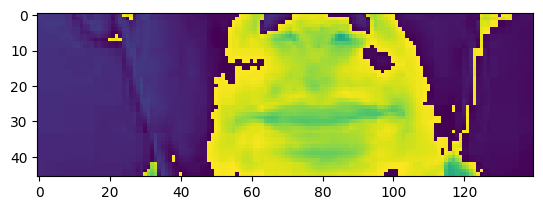

In [ ]:
plt.imshow(frames[0])

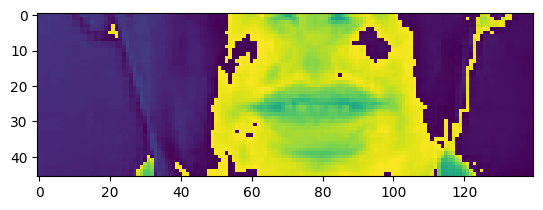

In [ ]:
plt.imshow(frames[20])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

#Create Data Pipeline

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')

dataset_list = list(data.as_numpy_iterator())
total_count = len(dataset_list)
print("Total number of items in the dataset:", total_count)

data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
#Added for split
train = data.take(450)
test = data.skip(450)

Total number of items in the dataset: 1000


In [ ]:
data.as_numpy_iterator().next()

(array([[[[[ 1.2531726 ],
           [ 1.2531726 ],
           [ 1.2531726 ],
           ...,
           [ 0.16934766],
           [ 0.20321718],
           [ 0.20321718]],
 
          [[ 1.2531726 ],
           [ 1.2531726 ],
           [ 1.2531726 ],
           ...,
           [ 0.20321718],
           [ 0.20321718],
           [ 0.20321718]],
 
          [[ 1.151564  ],
           [ 1.151564  ],
           [ 1.151564  ],
           ...,
           [ 0.20321718],
           [ 0.10160859],
           [ 0.10160859]],
 
          ...,
 
          [[ 0.8806078 ],
           [ 0.8806078 ],
           [ 0.8806078 ],
           ...,
           [ 8.433513  ],
           [ 8.501252  ],
           [ 8.331904  ]],
 
          [[ 0.8467383 ],
           [ 0.8467383 ],
           [ 0.8467383 ],
           ...,
           [ 8.196426  ],
           [ 8.433513  ],
           [ 8.162557  ]],
 
          [[ 0.8467383 ],
           [ 0.8467383 ],
           [ 0.8467383 ],
           ...,
           [ 7

In [ ]:
len(test)

50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next()
val[0]

array([[[[[1.4611986 ],
          [1.4611986 ],
          [1.4237319 ],
          ...,
          [0.56199944],
          [0.29973304],
          [8.954524  ]],

         [[1.4611986 ],
          [1.4611986 ],
          [1.4237319 ],
          ...,
          [0.48706618],
          [9.254257  ],
          [8.692258  ]],

         [[1.3862653 ],
          [1.3862653 ],
          [1.3862653 ],
          ...,
          [9.216791  ],
          [9.254257  ],
          [9.216791  ]],

         ...,

         [[0.97413236],
          [0.97413236],
          [0.97413236],
          ...,
          [0.07493326],
          [0.07493326],
          [0.03746663]],

         [[0.97413236],
          [0.97413236],
          [0.97413236],
          ...,
          [0.03746663],
          [0.        ],
          [9.55399   ]],

         [[0.97413236],
          [0.97413236],
          [0.97413236],
          ...,
          [0.        ],
          [9.55399   ],
          [9.55399   ]]],


        [[[1.3862

In [ ]:
# Save the image
imageio.mimsave('./animation.gif', val[0][1], fps=10)

TypeError: ignored

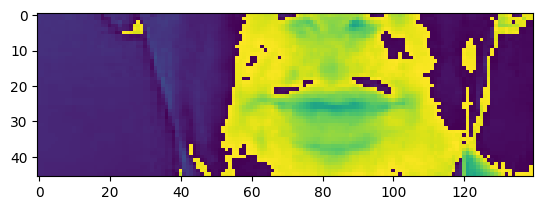

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green with q one again'>

In [ ]:
data.as_numpy_iterator().next()[0][1].shape

(75, 46, 140, 1)

#Designing Deep neural net

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
val[1].shape

(2, 40)

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 12s 12s/step


In [ ]:
yhat

array([[[0.02177923, 0.0222373 , 0.02528833, ..., 0.02714512,
         0.0267448 , 0.02022712],
        [0.022249  , 0.02148968, 0.02590862, ..., 0.02801476,
         0.02734441, 0.02059112],
        [0.02266118, 0.02107737, 0.02645844, ..., 0.02852018,
         0.02759611, 0.02088102],
        ...,
        [0.02861285, 0.02052436, 0.02683417, ..., 0.02942146,
         0.02589678, 0.02468121],
        [0.02813265, 0.02093491, 0.02668414, ..., 0.02875047,
         0.02565737, 0.02517636],
        [0.0274052 , 0.02146276, 0.02661244, ..., 0.02821532,
         0.02561581, 0.0253914 ]],

       [[0.02092012, 0.02287358, 0.02504619, ..., 0.02698081,
         0.02613036, 0.02032662],
        [0.02161434, 0.02219011, 0.02555535, ..., 0.02799353,
         0.02651647, 0.02058391],
        [0.02231461, 0.02179628, 0.02603499, ..., 0.02880363,
         0.02678611, 0.0208879 ],
        ...,
        [0.02867667, 0.02064665, 0.02653068, ..., 0.02917011,
         0.02473558, 0.02194665],
        [0.0

In [ ]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([18, 18,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5])>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'rreeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'>

In [ ]:
[num_to_char(x) for x in tf.argmax(yhat[0],axis=1)]

[<tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'r'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'e'>,


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'rreeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# Callbacks and Training

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


KeyboardInterrupt: ignored

#Predictions

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 51.1MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
sample[0]

array([[[[[1.4030454 ],
          [1.5138121 ],
          [1.5507344 ],
          ...,
          [0.29537797],
          [0.36922246],
          [0.36922246]],

         [[1.4768898 ],
          [1.5138121 ],
          [1.5507344 ],
          ...,
          [0.29537797],
          [0.36922246],
          [0.36922246]],

         [[1.5507344 ],
          [1.5507344 ],
          [1.4768898 ],
          ...,
          [0.4061447 ],
          [0.33230022],
          [0.33230022]],

         ...,

         [[1.0707451 ],
          [1.0338229 ],
          [1.0338229 ],
          ...,
          [0.11076674],
          [0.11076674],
          [0.11076674]],

         [[1.0338229 ],
          [1.0338229 ],
          [1.0338229 ],
          ...,
          [0.11076674],
          [0.11076674],
          [0.11076674]],

         [[1.0338229 ],
          [1.0338229 ],
          [1.0338229 ],
          ...,
          [0.11076674],
          [0.11076674],
          [0.07384449]]],


        [[[1.4768

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 14s 14s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue in t three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in r six now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
decoded

array([[19,  5, 20, 39,  2, 12, 21,  5, 39,  9, 14, 39, 20, 39, 20,  8,
        18,  5,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 2,  9, 14, 39,  2, 12, 21,  5, 39,  9, 14, 39, 18, 39, 19,  9,
        24, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [ ]:
len(decoded)

2

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set blue in t three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in r six now'>]